# Cross Language Generalization of Steering Vectors

In [61]:
import os
import sys
import pandas as pd

In [2]:
sys.path.append('../..')

In [54]:
# import get data dir from load_and_get_utils
from utils.load_and_get_utils import load_dataset, get_device, get_data_dir

In [5]:
imdb_sentiment_test = load_dataset(dataset_name='imdb_sentiment_test')
imdb_sentiment_train = load_dataset(dataset_name='imdb_sentiment_train')

2024-08-07 10:58:05,856 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current/masters_thesis/code/kasl_repe/data.
2024-08-07 10:58:05,910 - INFO - Successfully loaded imdb_sentiment_test dataset.
2024-08-07 10:58:05,911 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current/masters_thesis/code/kasl_repe/data.
2024-08-07 10:58:05,931 - INFO - Successfully loaded imdb_sentiment_train dataset.


In [6]:
# 1. Shape of the Dataset
print("Training Set Shape:", imdb_sentiment_train.shape)
print("Testing Set Shape:", imdb_sentiment_test.shape)

Training Set Shape: (25000, 2)
Testing Set Shape: (25000, 2)


In [7]:
# 2. Preview of Data
print("Training Data Preview:")
print(imdb_sentiment_train.head())
print("Testing Data Preview:")
print(imdb_sentiment_test.head())

Training Data Preview:
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0
Testing Data Preview:
                                                text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average film with a few semi-alr...      0
3  STAR RATING: ***** Saturday Night **** Friday ...      0
4  First off let me say, If you haven't enjoyed a...      0


In [8]:
# 3. Summary Statistics
print("Training Data Description:")
print(imdb_sentiment_train.describe())
print("Testing Data Description:")
print(imdb_sentiment_test.describe())

Training Data Description:
             label
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000
Testing Data Description:
             label
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000


In [9]:
# 4. Null Value Check
print("Missing Values in Training Data:")
print(imdb_sentiment_train.isnull().sum())
print("Missing Values in Testing Data:")
print(imdb_sentiment_test.isnull().sum())

Missing Values in Training Data:
text     0
label    0
dtype: int64
Missing Values in Testing Data:
text     0
label    0
dtype: int64


In [10]:
# 5. Distribution of the Target Variable
print("Distribution of Target in Training Data:")
print(imdb_sentiment_train['label'].value_counts())
print("Distribution of Target in Testing Data:")
print(imdb_sentiment_test['label'].value_counts())

Distribution of Target in Training Data:
label
0    12500
1    12500
Name: count, dtype: int64
Distribution of Target in Testing Data:
label
0    12500
1    12500
Name: count, dtype: int64


In [42]:
from typing import List, Tuple

def create_pos_neg_tuples(data: pd.DataFrame, num_samples: int) -> List[Tuple[str, str]]:
    '''
    Create tuples of positive and negative samples from the dataset where each text is under 400 tokens.
    The positive sample (label=1) is always first and the negative sample (label=0) second.
    
    :param data: The DataFrame containing the sentiment data.
    :param num_samples: The number of positive and negative samples to pair.
    :return: A list of tuples with each tuple containing a positive and a negative sample.
    '''
    # Filter texts by token count
    data['token_count'] = data['text'].apply(lambda x: len(x.split()))
    data_short = data[data['token_count'] <= 200]
    
    # Filter out positive and negative samples
    positive_samples = data_short[data_short['label'] == 1].head(num_samples)
    negative_samples = data_short[data_short['label'] == 0].head(num_samples)
    
    # Create tuples of (positive_text, negative_text)
    pos_neg_tuples = [(pos, neg) for pos, neg in zip(positive_samples['text'], negative_samples['text'])]
    
    return pos_neg_tuples

In [43]:
# Example usage: Assuming imdb_sentiment_train is your DataFrame loaded elsewhere
num_samples = 5  # You can change this to any number you need
training_tuples_en = create_pos_neg_tuples(imdb_sentiment_train, num_samples)

# Print the first 5 tuples to verify
print(training_tuples_en[:5])
# print the shape of the training tuples
print(len(training_tuples_en))
print(len(training_tuples_en[0]))

[('Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn\'t really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I\'d have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.', "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discerna

In [44]:
from transformers import pipeline

In [47]:
# function to translate given tuples in a given language to a target language
def translate_tuples(tuples: List[Tuple[str, str]], source_lang: str, target_lang: str) -> List[Tuple[str, str]]:
    '''
    Translate a list of tuples from a source language to a target language.
    
    :param tuples: A list of tuples to translate.
    :param source_lang: The language of the source text.
    :param target_lang: The language to translate the source text to.
    :return: A list of tuples with the source text translated to the target language.
    '''
    # Initialize the translation pipeline
    device = get_device(device_map='auto')
    translation_pipeline = pipeline(task=f'translation_{source_lang}_to_{target_lang}',
                                    model=f'Helsinki-NLP/opus-mt-{source_lang}-{target_lang}',
                                    device=device)
    
    # Translate each tuple
    translated_tuples = [(translation_pipeline(tup[0])[0]['translation_text'],
                          translation_pipeline(tup[1])[0]['translation_text']) for tup in tuples]
    
    return translated_tuples

In [48]:
# translate the tuples to German and French and store them
training_tuples_de = translate_tuples(training_tuples_en, 'en', 'de')
training_tuples_fr = translate_tuples(training_tuples_en, 'en', 'fr')

2024-08-07 12:20:46,425 - INFO - Using device: mps
2024-08-07 12:21:12,136 - INFO - Using device: mps


In [49]:
print(training_tuples_de[:5])

[('Zentropa hat viel mit The Third Man gemein, einem anderen noir-like Film, der unter den Trümmern des Nachkriegseuropas spielt. Wie TTM gibt es viel erfinderische Kameraarbeit. Es gibt einen unschuldigen Amerikaner, der emotional mit einer Frau zu tun hat, die er nicht wirklich versteht, und deren Naivität im Gegensatz zu den Eingeborenen umso auffälliger ist. <br /><br />Aber ich müsste sagen, dass The Third Man eine wohlgefertigtere Handlungslinie hat. Zentropa ist in dieser Hinsicht etwas unzusammenhängend. Vielleicht ist dies beabsichtigt: Es wird als Traum/Nightmare präsentiert und es zu kohärent zu machen würde den Effekt verderben. <br /><br />Dieser Film ist in mehr als einem Sinne unerbittlich grim-"noir"; man sieht die Sonne nie. Grim, aber faszinierend und erschreckend.', 'Dieser Film ist interessant als Experiment, aber er erzählt keine gekonnte Geschichte. <br /> <br />Man mag sich tugendhaft fühlen, wenn man durch ihn sitzt, weil er so viele WICHTIGE Themen berührt, abe

In [38]:
print(training_tuples_fr[:5])

[('Zentropa a beaucoup en commun avec The Third Man, un autre film de type noir qui se trouve parmi les décombres de l\'Europe d\'après-guerre. Comme TTM, il y a beaucoup de travail de caméra inventive. Il y a un Américain innocent qui s\'implique émotionnellement avec une femme qu\'il ne comprend pas vraiment, et dont la naïveté est d\'autant plus frappante en contraste avec les natifs.<br /><br />Mais je dois dire que The Third Man a une histoire plus bien faite. Zentropa est un peu déconcertée à cet égard. Peut-être ceci est intentionnel: il est présenté comme un rêve / nightmare, et le rendre trop cohérent gâcherait l\'effet. <br /><br />Ce film est inlassablement sombre - "noir" dans plus d\'un sens; on ne voit jamais le soleil briller. Grim, mais intrigant, et effrayant.', '"I Am Curious: Yellow" est une pile de vapeurs risible et prétentieuse. Peu importe ce que sont les vues politiques de l\'homme parce que ce film ne peut être pris au sérieux sur aucun niveau. Quant à l\'affir

In [58]:
# store the tuples in a json file, include the sample size, language and imdb_sentiment in the filename
import json

def store_tuples(tuples: List[Tuple[str, str]], sample_size: int, language: str, dataset_name: str):
    '''
    Store a list of tuples in a JSON file with the given metadata.
    
    :param tuples: A list of tuples to store.
    :param sample_size: The number of samples in the list.
    :param language: The language of the tuples.
    :param dataset_name: The name of the dataset the tuples are from.
    '''
    # Create a dictionary to store the metadata and tuples
    data = {
        'sample_size': sample_size,
        'language': language,
        'dataset': dataset_name,
        'tuples': tuples
    }
    
    # Store the data in a JSON file
    data_folder = get_data_dir(os.getcwd())
    filename = f'{dataset_name}_{language}_{sample_size}.json'
    file_path = os.path.join(data_folder, 'sentiment_vectors_data', filename)

    # store with indent=4 for pretty printing

    with open(file=file_path, mode='w') as f:
        json.dump(data, f, indent=4)
    

In [59]:
# function that generates training tuples and stores them in a json file
# input: list of languages (e.g. ['en', 'de', 'fr']), sample size, dataset name (set to 'imdb_sentiment_train')
def generate_and_store_training_tuples(languages: List[str], sample_size: int, dataset_name: str):
    '''
    Generate and store training tuples for each language in the list.
    
    :param languages: A list of languages to generate tuples for.
    :param sample_size: The number of samples to generate for each language.
    :param dataset_name: The name of the dataset to generate tuples from.
    '''
    # Load the dataset
    data = load_dataset(dataset_name)
    
    # Generate and store training tuples for each language
    for lang in languages:
        # Generate training tuples
        training_tuples = create_pos_neg_tuples(data, sample_size)
        
        # Translate the training tuples
        if lang != 'en':
            training_tuples = translate_tuples(training_tuples, 'en', lang)
        
        # Store the training tuples
        store_tuples(training_tuples, sample_size, lang, dataset_name)


In [60]:
generate_and_store_training_tuples(['en', 'de', 'fr'], 5, 'imdb_sentiment_train')

2024-08-07 13:03:47,538 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current/masters_thesis/code/kasl_repe/data.
2024-08-07 13:03:47,559 - INFO - Successfully loaded imdb_sentiment_train dataset.
2024-08-07 13:03:47,723 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current/masters_thesis/code/kasl_repe/data.
2024-08-07 13:03:47,882 - INFO - Using device: mps
2024-08-07 13:04:14,697 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current/masters_thesis/code/kasl_repe/data.
2024-08-07 13:04:14,861 - INFO - Using device: mps
2024-08-07 13:04:41,671 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current/masters_thesis/code/kasl_repe/data.


In [ ]:
# Sentiment analysis

# bert-base-multilingual-uncased-sentiment can do sentiment analysis in English, German, French, ...
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
pipe = pipeline(task='sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

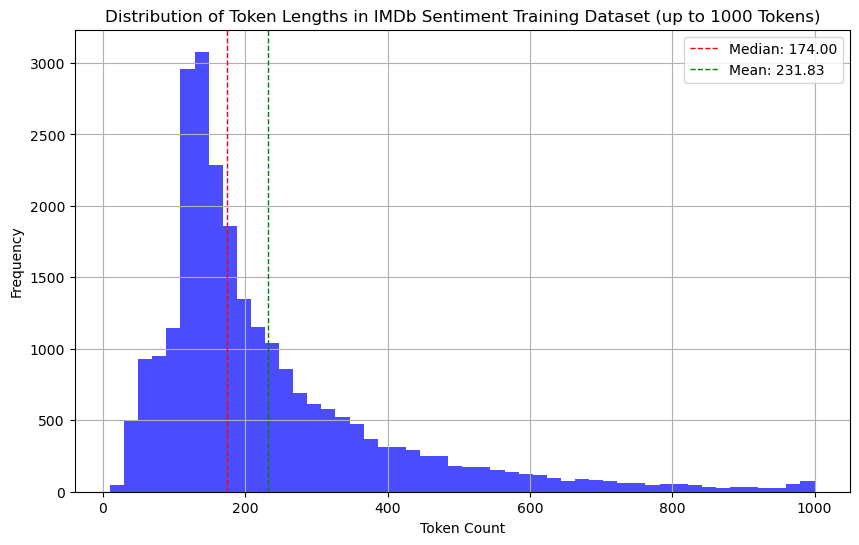

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming imdb_sentiment_train is your DataFrame loaded elsewhere

# Calculate token counts for each text
imdb_sentiment_train['token_count'] = imdb_sentiment_train['text'].apply(lambda x: len(x.split()))

# Focus on entries with token counts up to 1000
max_token_limit = 1000
filtered_data = imdb_sentiment_train[imdb_sentiment_train['token_count'] <= max_token_limit]

# Calculate median and mean
median_token_count = np.median(filtered_data['token_count'])
mean_token_count = np.mean(filtered_data['token_count'])

# Plotting the distribution of token counts
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['token_count'], bins=50, color='blue', alpha=0.7)
plt.axvline(median_token_count, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_token_count:.2f}')
plt.axvline(mean_token_count, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean_token_count:.2f}')
plt.title('Distribution of Token Lengths in IMDb Sentiment Training Dataset (up to 1000 Tokens)')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
